In [106]:
from plots.plot_utils import load_pickle
example_pkl = "/home/scratch/yixiz/results/test_seeds/boston/test/boston_lossbatch_int_ens1_bootFalse_resFalse_lnFalse_bnFalse_dr0.0_lr0.001_bs64_nl2_hs64_4.pkl"
baseline_names = ['batch_qr', 'batch_int', 'batch_cal']
seeds = [0, 1, 2, 3, 4]
seed_pkls = [example_pkl.replace("_4", "_{}".format(seed)) for seed in seeds]
print(seed_pkls)
import numpy as np
def get_quantile_seed_idxs(seed_pkls, quantile=0.5):
    datas = [load_pickle(pkl) for pkl in seed_pkls]
    va_sharp_score_thresholded = np.full((5, 150), 1.0)
    for i, data in enumerate(datas):
        va_sharp_score_thresholded[i, -len(data['va_sharp_score_thresholded']):] = data['va_sharp_score_thresholded']

    order = np.argsort(va_sharp_score_thresholded, axis=0)
    q_idx = int(quantile * len(seed_pkls) - 1)
    quantile_seed_idxs = order[q_idx, np.arange(order.shape[1])]
    return quantile_seed_idxs

def aggregate_seeds(seed_pkls, quantile=0.5):
    datas = [load_pickle(pkl) for pkl in seed_pkls]
    
    quantile_seed_idxs = get_quantile_seed_idxs(seed_pkls, quantile)

    te_sharp_score_thresholded = np.full((5, 150), 1.0)
    te_ece_thresholded = np.full((5, 150), 1.0)
    va_sharp_score_thresholded = np.full((5, 150), 1.0)
    va_ece_thresholded = np.full((5, 150), 1.0)
    for i, data in enumerate(datas):
        te_sharp_score_thresholded[i, -len(data['te_sharp_score_thresholded']):] = data['te_sharp_score_thresholded']
        te_ece_thresholded[i, -len(data['te_ece_thresholded']):] = data['te_ece_thresholded']
        va_sharp_score_thresholded[i, -len(data['va_sharp_score_thresholded']):] = data['va_sharp_score_thresholded']
        va_ece_thresholded[i, -len(data['va_ece_thresholded']):] = data['va_ece_thresholded']

    # retrieve test scores based on quantile seed idxs
    threshold_to_test_ece_sharp = {}
    for thres_idx, threshold in enumerate(np.linspace(0.001, 0.15, 150)):
        seed_idx = quantile_seed_idxs[thres_idx]
        te_ece = te_ece_thresholded[seed_idx, thres_idx]
        te_sharp = te_sharp_score_thresholded[seed_idx, thres_idx]
        va_ece = va_ece_thresholded[seed_idx, thres_idx]
        va_sharp = va_sharp_score_thresholded[seed_idx, thres_idx]
        if te_ece == 1.0 and te_sharp == 1.0:
            continue
        threshold_to_test_ece_sharp[float(threshold)] = {'te_ece': float(te_ece), 'te_sharp_score': float(te_sharp),
                                                         'va_ece': float(va_ece), "va_sharp_score": float(va_sharp)}
    
    return threshold_to_test_ece_sharp

import matplotlib.pyplot as plt
def plot_and_compute_mean_deviation(threshold_to_test_ece_sharp, baseline_name, dataset):
    te_ece = [dic['te_ece'] for dic in threshold_to_test_ece_sharp.values()]
    va_ece = [dic['va_ece'] for dic in threshold_to_test_ece_sharp.values()]
    thresholds = list(threshold_to_test_ece_sharp.keys()) 
    below_thres_prop = len([dic['te_ece'] - thres for thres, dic in threshold_to_test_ece_sharp.items() if dic['te_ece'] <= thres]) / float(len(te_ece))
    mean_exceedance = np.mean([dic['te_ece'] - thres for thres, dic in threshold_to_test_ece_sharp.items() if dic['te_ece'] > thres])
    plt.scatter(thresholds, np.maximum(np.array(te_ece) - np.array(thresholds), 0), label=f"{baseline_name}: p-{below_thres_prop:.1%} m-{mean_exceedance:.3f}")
    plt.title(f"{dataset} - p=proportion of below threshold; m=mean exceedance (only counting exceeding points)")
    plt.xlabel('ECE Threshold')
    plt.ylabel('ECE max(Test - Threshold, 0)')
    plt.legend()
    return below_thres_prop, mean_exceedance

['/home/scratch/yixiz/results/test_seeds/boston/test/boston_lossbatch_int_ens1_bootFalse_resFalse_lnFalse_bnFalse_dr0.0_lr0.001_bs64_nl2_hs64_0.pkl', '/home/scratch/yixiz/results/test_seeds/boston/test/boston_lossbatch_int_ens1_bootFalse_resFalse_lnFalse_bnFalse_dr0.0_lr0.001_bs64_nl2_hs64_1.pkl', '/home/scratch/yixiz/results/test_seeds/boston/test/boston_lossbatch_int_ens1_bootFalse_resFalse_lnFalse_bnFalse_dr0.0_lr0.001_bs64_nl2_hs64_2.pkl', '/home/scratch/yixiz/results/test_seeds/boston/test/boston_lossbatch_int_ens1_bootFalse_resFalse_lnFalse_bnFalse_dr0.0_lr0.001_bs64_nl2_hs64_3.pkl', '/home/scratch/yixiz/results/test_seeds/boston/test/boston_lossbatch_int_ens1_bootFalse_resFalse_lnFalse_bnFalse_dr0.0_lr0.001_bs64_nl2_hs64_4.pkl']


batch_qr: 0.8985507246376812, 0.0035026881098747242
batch_int: 0.7216494845360825, 0.012454496535989968


/home/scratch/yixiz/anaconda3/envs/cali/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/scratch/yixiz/anaconda3/envs/cali/lib/python3.10/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


batch_cal: 1.0, nan


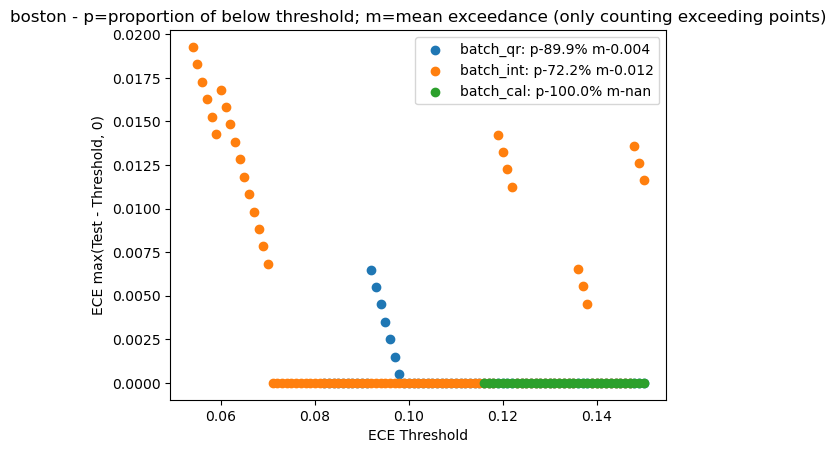

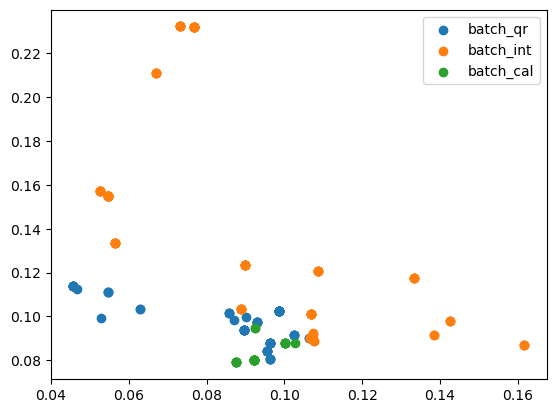

In [118]:
baseline_data = {}
for baseline_name in baseline_names:
    pkl = example_pkl.replace("batch_int", baseline_name)
    seed_pkls = [pkl.replace("_4", "_{}".format(seed)) for seed in seeds]
    baseline_aggregated = aggregate_seeds(seed_pkls, quantile=0.0)
    below_thres_prop, mean_exceedance = plot_and_compute_mean_deviation(baseline_aggregated, baseline_name, "boston")
    print(f"{baseline_name}: {below_thres_prop}, {mean_exceedance}")
    baseline_data[baseline_name] = baseline_aggregated
plt.show()
plt.close()

import matplotlib.pyplot as plt
for baseline_name, baseline_aggregated in baseline_data.items():
    te_ece = [dic['te_ece'] for dic in baseline_aggregated.values()]
    te_sharp = [dic['te_sharp_score'] for dic in baseline_aggregated.values()]
    plt.scatter(te_ece, te_sharp, label=baseline_name)
plt.legend()

In [114]:
sorted([dic['te_ece'] for dic in threshold_to_test_ece_sharp.values()])

[0.06127550080418587,
 0.06127550080418587,
 0.06127550080418587,
 0.06127550080418587,
 0.06127550080418587,
 0.06127550080418587,
 0.06299465894699097,
 0.06299465894699097,
 0.06299465894699097,
 0.06299465894699097,
 0.06299465894699097,
 0.06610418856143951,
 0.06713806092739105,
 0.0677362009882927,
 0.0677362009882927,
 0.0677362009882927,
 0.0677362009882927,
 0.0677362009882927,
 0.06852447241544724,
 0.06852447241544724,
 0.07070311903953552,
 0.07420875877141953,
 0.07420875877141953,
 0.07420875877141953,
 0.07420875877141953,
 0.07420875877141953,
 0.07420875877141953,
 0.07420875877141953,
 0.07554763555526733,
 0.07891464233398438,
 0.07998020201921463,
 0.07998020201921463,
 0.07998020201921463,
 0.07998020201921463,
 0.07998020201921463,
 0.07998020201921463,
 0.08068530261516571,
 0.08068530261516571,
 0.08241236209869385,
 0.08379877358675003,
 0.08518519252538681,
 0.08914637565612793,
 0.08914637565612793,
 0.08914637565612793,
 0.08914637565612793,
 0.089146375656

In [10]:
from plots.plot_utils import load_pickle
from data.fetch_data import get_uci_data
pkl = load_pickle("/home/scratch/yixiz/results/test/boston/test/boston_lossbatch_cal_ens1_bootFalse_resFalse_lnFalse_bnFalse_dr0.0_lr0.001_bs64_nl1_hs32_4.pkl")
pkl.keys()

from argparse import Namespace
args = Namespace(data_dir='data/UCI_Datasets', data='boston', seed=0)
data = get_uci_data(args)
x_te, y_te = data.x_te, data.y_te

0.039682548493146896


tensor(1.0505)

In [14]:
for key, value in pkl.items():
    print(key, type(value), value if isinstance(value, (int, float, str)) else (value.shape if hasattr(value, 'shape') else len(value)))

model_controlled <class 'list'> 16
va_sharp_score_controlled <class 'list'> 16
te_sharp_score_controlled <class 'list'> 16
va_ece_controlled <class 'list'> 16
te_ece_controlled <class 'list'> 16
va_variance_controlled <class 'list'> 16
va_cali_score_controlled <class 'list'> 16
va_obs_props_controlled <class 'list'> 16
va_q_preds_controlled <class 'list'> 16
va_g_cali_scores_controlled <class 'list'> 16
va_scoring_rules_controlled <class 'list'> 16
va_bag_nll_controlled <class 'list'> 16
va_crps_controlled <class 'list'> 16
va_mpiw_controlled <class 'list'> 16
va_interval_controlled <class 'list'> 16
va_check_controlled <class 'list'> 16
te_variance_controlled <class 'list'> 16
te_cali_score_controlled <class 'list'> 16
te_obs_props_controlled <class 'list'> 16
te_q_preds_controlled <class 'list'> 16
te_g_cali_scores_controlled <class 'list'> 16
te_scoring_rules_controlled <class 'list'> 16
te_bag_nll_controlled <class 'list'> 16
te_crps_controlled <class 'list'> 16
te_mpiw_controlled 

TypeError: object of type 'Namespace' has no len()